In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift, fftfreq
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.transforms as mtransforms

In [2]:
# Shared plotting options
heatmap_imopts = {
    "cmap":'RdPu', 
    "interpolation":'bicubic', 
    "aspect":"auto",
    "origin": "lower"
}

polariton_imopts = {
    "cmap":'Purples',
    "interpolation":'bicubic',
    "aspect":"auto",
    "origin": "lower"
}

plt.rcParams["text.usetex"] = True
#ax.tick_params(direction="in")

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 32
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE,
        xmargin=0, # between data and axes
        labelsize=22)     # x and y axis labels
#ax.autoscale(enable=True, axis='x', tight=True) # alternative to xmargin, for individual axes
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [3]:
# Load the data from a file
def load_instance(filename):
    with h5py.File(filename, "r") as f:
        dst = f['1'] # Dataset
        t, z, = (dst['t'][:], dst['z'][:])
        S_im, S_re, E_im, E_re = (dst['SI'][:], dst['SR'][:], dst['EI'][:], dst['ER'][:])
        # Indexing with [:] converts from 'dataset' to 'np.ndarray'.
        # Each row corresponds with a time, and each column with a z-position.
        S = S_re + S_im * 1j
        E = E_re + E_im * 1j
        return (t, z, E, S)

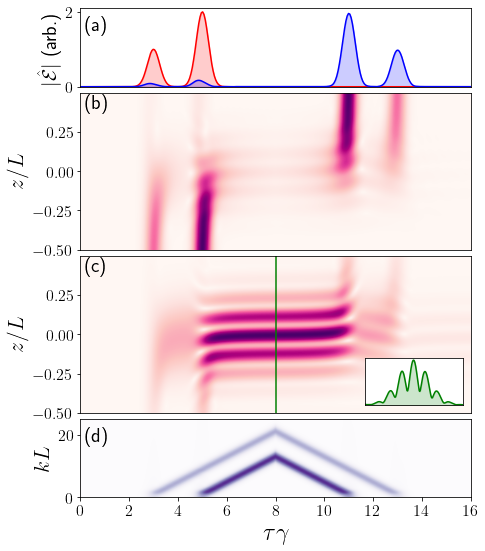

In [5]:
def pulse_representations():
    uneven = load_instance("./instances/uneven-gaussians/uneven-double-gaussian.h5")
    t,z,E,S =uneven
    
    fig, axs = plt.subplots(4,1, figsize=(7,9), gridspec_kw={"height_ratios":[1,2,2,1]})
    (axPulse, axProbe, axSpin, axK) = axs
    
    # Probe pulse
    uneven_in = np.abs(E[:,0])
    uneven_out = np.abs(E[:,-1])
    axPulse.plot(t, uneven_in, color="red")
    axPulse.fill_between(t, uneven_in, color="red",alpha=0.2)
    axPulse.plot(t, uneven_out, color="blue")
    axPulse.fill_between(t, uneven_out, color="blue",alpha=0.2)
    axPulse.set_xlim(min(t),max(t))
    axPulse.set_ylabel("$|\\hat{\\mathcal{E}}|$ (arb.)", fontsize=20)
    axPulse.set_ylim(bottom=0)
    #axPulse.set_yticks([0])
    
    # Probe heatmap
    axProbe.imshow(np.abs(E.T), **heatmap_imopts, extent=[min(t), max(t), min(z), max(z)])
    axProbe.set_ylabel("$z/L$")
    
    # Spinwave heatmap
    axSpin.imshow(np.abs(S.T), **heatmap_imopts, extent=[min(t), max(t), min(z), max(z)])
    axSpin.set_ylabel("$z/L$")
    
    # Spinwave inset
    axSpin.axvline(8, ls="-", color="green")
    axin = axSpin.inset_axes([0.73, 0.05, 0.25, 0.3])
    spinprofile = np.abs(S[150,:])
    axin.plot(z, spinprofile,c="green")
    axin.fill_between(z, spinprofile, color="green",alpha=0.2)
    axin.set_xticks([])
    axin.set_yticks([])
    axin.set_ylim(bottom=0)
    #for spine in axin.spines.values():
    #    spine.set_edgecolor('orange')
    
    # Probe and spinwave z-axes
    axProbe.get_xticklabels()
    
    # Polariton picture
    kwave = np.zeros( shape=S.shape, dtype=complex)
    for i in range(len(t)):
        kwave[i,:] = fftshift(fft(S[i,:]))
    ks = fftshift(fftfreq(len(z), (max(z)-min(z))/len(z)))
    jmin, jmax = (350, 375)
    axK.imshow(np.abs(kwave[:,jmin:jmax]).T, **polariton_imopts, extent=[min(t), max(t), ks[jmin], ks[jmax]])
    axK.set_ylabel("$kL$")
    
    # Single time axis
    for ax in [axPulse, axProbe, axSpin]:
        ax.set_xticks([])
    axK.set_xlabel("$\\tau \\gamma$", fontsize=24)
    
    # Plot letters
    axPulse.text(0.2, 1.5, "(a)", fontsize=20)
    axProbe.text(0.2, 0.4, "(b)", fontsize=20)
    axSpin.text(0.2, 0.4, "(c)", fontsize=20)
    axK.text(0.2, 18, "(d)", fontsize=20)
  
    fig.subplots_adjust(wspace=0, hspace=0.05)
    plt.savefig("./figures/pulse-representations.png", dpi=300, bbox_inches='tight')
    
pulse_representations()

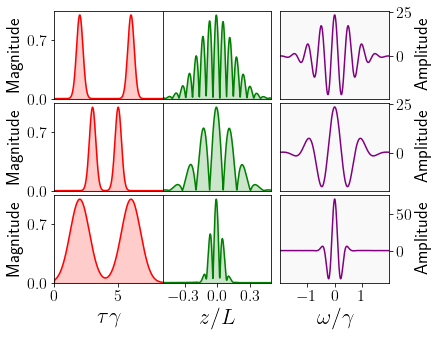

In [4]:
# Fourier transform
def fourier_spinwave():
    instances = [
        load_instance("./instances/double-gaussian/pulsewidth=0.5.pulsesep=4.h5"),
        load_instance("./instances/double-gaussian/pulsewidth=0.5.pulsesep=2.h5"),
        load_instance("./instances/double-gaussian/pulsewidth=1.5.pulsesep=4.h5")
    ]
    
    fig, axs = plt.subplots(3,4, figsize=(6,5), gridspec_kw={"width_ratios":[1,1,0.08,1]})
    # Blank column to create space between left and right sections.
    
    phase_offsets = [359j,359j,359j]
    
    # Plot each row
    for i in range(3):
        t, z, E, S = instances[i]
        axL, axM, axInvis, axR = axs[i,:]
        
        axInvis.set_visible(False)
        
        tin, Ein = t[:160], E[:160, 0]
        axL.plot(tin, np.abs(Ein), c="red")
        axL.fill_between(tin, np.abs(Ein), color="red",alpha=0.2)
        axL.set_ylabel("Magnitude", fontsize=18)
        axL.set_yticks([0, 0.7])
        
        S_switch_abs = np.abs(S[ int(len(t)/2) ,:])
        axM.plot(z, S_switch_abs, c="green")
        axM.fill_between(z, S_switch_abs, color="green",alpha=0.2)
        axM.set_yticks([])
        
        E_longtime = np.pad(E[:160,0], 1000) # pad with zeros
        omegas = fftshift(fftfreq(len(E_longtime), d=(max(t)-min(t))/len(t)))
        # Take Fourier transform and phase-offset
        ft = fftshift(fft(E_longtime)) * np.exp(phase_offsets[i] * omegas)                    
        ft = ft[850:1310]
        omegas = omegas[850:1310]
        axR.plot(omegas, np.real(ft), color="purple")
        #axR.plot(omegas, np.imag(ft), color="black")
        #axR.fill_between(omegas, np.real(ft), color="green",alpha=0.2)
        axR.yaxis.tick_right()
        axR.yaxis.set_label_position("right")
        axR.set_ylabel("Amplitude", fontsize=18)
        #axR.set_yticks([0])
        axR.set_facecolor("#f9f9f9")
    
    # Set 0 to bottom on left-hand plots
    for ax in axs[:,:2].flatten():
        ax.set_ylim(bottom=0)
    
    # Remove bottom ticks
    for ax in axs[:2,:].flatten():
        ax.set_xticks([])
    
    # Bottom labels
    axs[2,0].set_xlabel("$\\tau \\gamma$")
    axs[2,1].set_xlabel("$z/L$")
    axs[2,1].set_xticks([-0.3, 0, 0.3])
    axs[2,3].set_xlabel("$\\omega/\\gamma$")
    axs[2,3].set_xticks([-1, 0, 1])
    
    # Single vertical axis label
    # axs[1,0].set_ylabel("Magnitude (arb.)", fontsize=25)
    
    # Formatting
    fig.subplots_adjust(wspace=0, hspace=0.05)
    plt.savefig("./figures/fourier-spinwave.png", dpi=300, bbox_inches='tight')
    
fourier_spinwave()

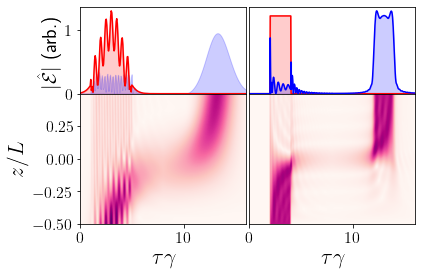

In [9]:
# Low-pass filter
def low_pass_filter():
    fig, axs = plt.subplots(2,2, gridspec_kw = {'height_ratios': [2, 3]})
    (axTL, axTR, axBL, axBR) = (axs[0,0], axs[0,1], axs[1,0], axs[1,1])
    
    # Dithered signal (left)
    dithered = load_instance("./instances/low-pass-filter/dithered-gaussian.h5")
    td, zd, Ed, Sd = dithered
        
    ## Heatmap of probe
    axBL.imshow(np.abs(Ed.T), **heatmap_imopts, extent=[min(td), max(td), min(zd), max(zd)])
    axBL.set_xlabel("$\\tau \\gamma$")
    axBL.set_ylabel("$z/L$")
    
    ## Time-plot of pulse
    dither_in = np.abs(Ed[:,0])
    dither_out = np.abs(Ed[:,-1])
    axTL.plot(td, dither_in, color="red")
    axTL.fill_between(td, dither_in, color="red",alpha=0.2)
    #axTL.plot(td, dither_out, color="blue")
    axTL.fill_between(td, dither_out, color="blue",alpha=0.2)
    
    axTL.set_ylabel("$|\\hat{\\mathcal{E}}|$ (arb.)", fontsize=20)
    axTL.set_xlim(min(td), max(td))
    axTL.set_xticks([])
    #axTL.set_yticks([0])
    axTL.set_ylim(bottom=0)
    
    # Square pulse (right) (illustrates Gibbs overshoot)
    square = load_instance("./instances/tophat-short/tophat-short.h5")
    ts, zs, Es, Ss = square
    
    ## Heatmap of probe
    axBR.imshow(np.abs(Es.T), **heatmap_imopts, extent=[min(ts), max(ts), min(zs), max(zs)])
    axBR.set_xlabel("$\\tau \\gamma$")
    axBR.set_yticks([])
    
    ## Time-plot of pulse
    axTR.set_yticks([])
    axTR.set_xticks([])
    square_in = np.abs(Es[:,0])
    square_out = np.abs(Es[:,-1])
    axTR.plot(ts, square_in, color="red")
    axTR.fill_between(ts, square_in, color="red",alpha=0.2)
    axTR.plot(ts, square_out, color="blue")
    axTR.fill_between(ts, square_out, color="blue",alpha=0.2)
    axTR.set_xlim(min(ts), max(ts))
    axTR.set_ylim(bottom=0)
    
    fig.subplots_adjust(wspace=0.02, hspace=0)
    plt.savefig("./figures/low-pass-filter.png", dpi=300, bbox_inches='tight')
    
low_pass_filter()

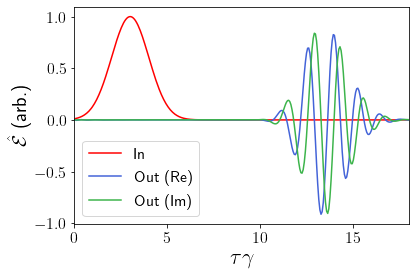

In [15]:
# Frequency offset
def frequency_offset():
    t, z, E, S = load_instance("./instances/nonlinear-recall/nonlinear-field.h5")
    
    Ein = E[:,0]
    Eout = E[:,-1]
    plt.plot(t, np.real(Ein), color="red", label="In")
    plt.plot(t, np.real(Eout), color="#4363d8", label="Out (Re)")
    plt.plot(t, np.imag(Eout), color="#3cb44b", label="Out (Im)")
    plt.ylabel("$\\hat{\\mathcal{E}}$ (arb.)", fontsize=20)
    plt.xlabel("$\\tau\\gamma$")
    plt.legend()
    
    plt.savefig("./figures/offset.png", dpi=300, bbox_inches='tight')

frequency_offset()

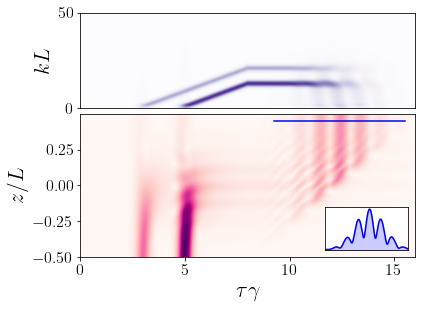

In [10]:
# Fourier recall
def fourier_recall():
    # Recreate 2010 Optica fig. 3
    t,z,E,S = load_instance("./instances/fourier-recall/fourier-recall.h5")
    
    fig, axs = plt.subplots(2,1,figsize=(6,4.5),gridspec_kw={"height_ratios":[2,3]})
    axK, axProbe = axs
    
    # Probe heatmap
    axProbe.imshow(np.abs(E.T), **heatmap_imopts, extent=[min(t), max(t), min(z), max(z)])
    axProbe.set_ylabel("$z/L$")
    axProbe.set_xlabel("$\\tau \\gamma$")
    
    # Probe inset
    axProbe.axhline(0.45, 0.58, 0.97, ls="-", color="b")
    axin = axProbe.inset_axes([0.73, 0.05, 0.25, 0.3])
    outprofile = np.abs(E[162:297,680])
    outt = t[162:297]
    axin.plot(outt, outprofile,c="blue")
    axin.fill_between(outt, outprofile, color="blue",alpha=0.2)
    axin.set_xticks([])
    axin.set_yticks([])
    axin.set_ylim(bottom=0)
    
    # Polariton picture
    kwave = np.zeros( shape=S.shape, dtype=complex)
    for i in range(len(t)):
        kwave[i,:] = fftshift(fft(S[i,:]))
    ks = fftshift(fftfreq(len(z), (max(z)-min(z))/len(z)))
    jmin, jmax = (350, 400)
    axK.imshow(np.abs(kwave[:,jmin:jmax]).T, **polariton_imopts, extent=[min(t), max(t), ks[jmin], ks[jmax]])
    axK.set_ylabel("$kL$")
    axK.set_xticks([])
    
    fig.subplots_adjust(wspace=0, hspace=0.05)
    plt.savefig("./figures/fourier-recall.png", dpi=300, bbox_inches='tight')
    
fourier_recall()

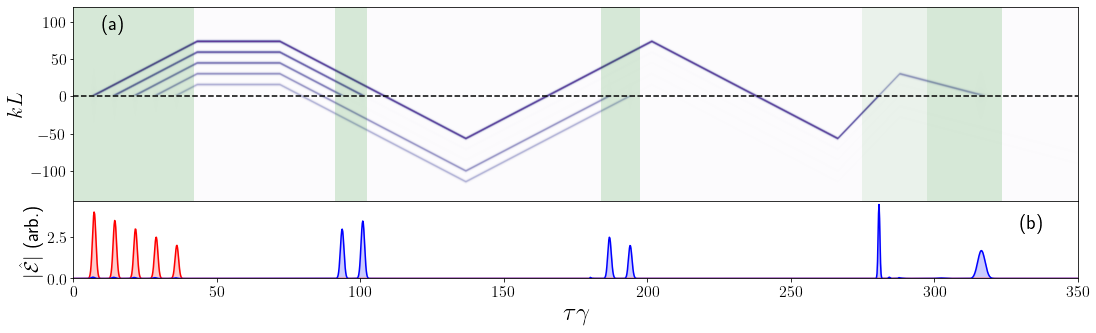

In [13]:
# Pulse sequencing
def recall_demo():
    sequenced = load_instance("./instances/sequencing/pulse-sequencing.h5")
    t,z,E,S = sequenced
    
    fig, axs = plt.subplots(2,1, figsize=(18,5), gridspec_kw={"height_ratios":[2.5,1]})
    (axK, axPulse) = axs
    
    # Probe pulse
    pulse_in = np.abs(E[:,0])
    pulse_out = np.abs(E[:,-1])
    axPulse.plot(t, pulse_in, color="red")
    axPulse.fill_between(t, pulse_in, color="red",alpha=0.2)
    axPulse.plot(t, pulse_out, color="blue")
    axPulse.fill_between(t, pulse_out, color="blue",alpha=0.2)
    axPulse.set_xlim(min(t),max(t))
    axPulse.set_ylabel("$|\\hat{\\mathcal{E}}|$ (arb.)", fontsize=20)
    axPulse.set_ylim(bottom=0)
    #axPulse.set_yticks([0])
    
    # Polariton picture
    kwave = np.zeros( shape=S.shape, dtype=complex)
    for i in range(len(t)):
        kwave[i,:] = fftshift(fft(S[i,:]))
    ks = fftshift(fftfreq(len(z), (max(z)-min(z))/len(z)))
    jmin, jmax = (210, 470)
    axK.imshow(np.abs(kwave[:,jmin:jmax]).T, **polariton_imopts, extent=[min(t), max(t), ks[jmin], ks[jmax]])
    axK.set_ylabel("$kL$")
    axK.axhline(0,ls='--',color="black")
    
    # Control field
    trans = mtransforms.blended_transform_factory(axK.transData, axK.transAxes)
    axK.fill_between(t[0:240], 0, 1,
                facecolor='green', alpha=0.15, transform=trans)
    axK.fill_between(t[520:585], 0, 1,
                facecolor='green', alpha=0.15, transform=trans)
    axK.fill_between(t[1050:1130], 0, 1,
                facecolor='green', alpha=0.15, transform=trans)
    axK.fill_between(t[1570:1701], 0, 1,
                facecolor='green', alpha=0.07, transform=trans)
    axK.fill_between(t[1700:1850], 0, 1,
                facecolor='green', alpha=0.15, transform=trans)
    
    # Single time axis
    axK.set_xticks([])
    axPulse.set_xlabel("$\\tau \\gamma$", fontsize=25)
    
    # Plot letters
    axPulse.text(330, 3, "(b)", fontsize=20)
    axK.text(10, 90, "(a)", fontsize=20)
  
    fig.subplots_adjust(wspace=0, hspace=0)
    #fig.tight_layout()
    plt.savefig("./figures/recall-demo.png", dpi=300, bbox_inches='tight')
    
recall_demo()